In [1]:
import Pkg; Pkg.add(["Plots", "StatsPlots"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; using StatsPlots; gr(); default(l=5, size=(900,550), label=false);
using Printf;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

**(follow along: <https://tinyurl.com/gtcse6643lec16>)**

### Warmup

Why choose partial pivoting of rows,

$$PA = LU,$$

instead of columns,

$$AQ = LU?$$

# Stability of Gaussian Elimination

**1. Review**

**2. Analysis of Unpivoted LU**

**3. Backward Stability Analysis**

**4. Worst-Case vs. Average Case Stability**

## Review

### LU Factorization (no pivoting) $\Leftrightarrow$ Gaussian elimination

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/lu.gif")
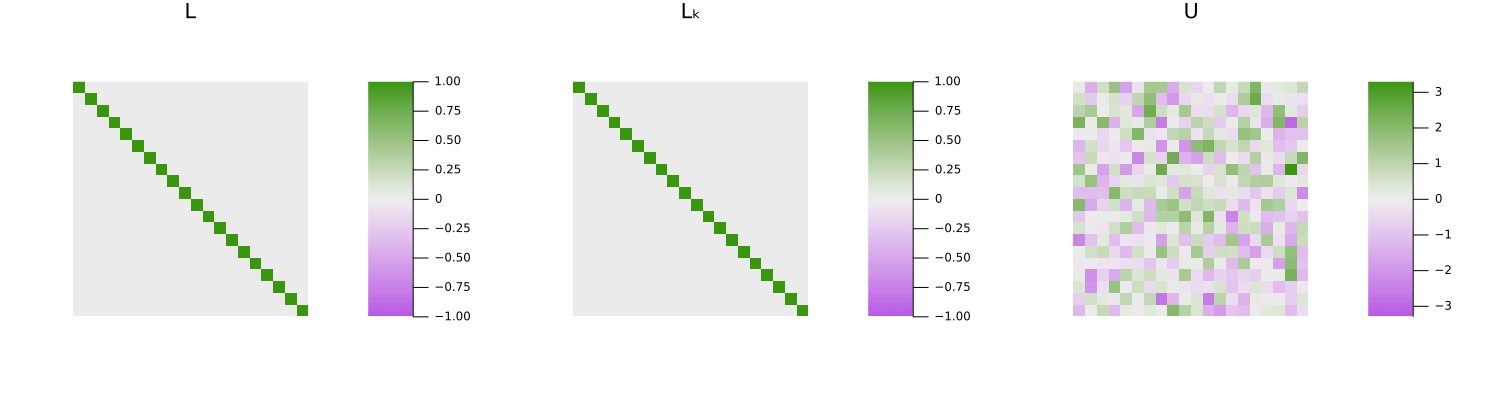

In [4]:
anim = Animation()
m = 20
A = randn(m,m)
U = copy(A)
LU = lu(A, NoPivot())
scale = max(norm(A,Inf),norm(LU.L,Inf),norm(LU.U,Inf))
L = Matrix(1.0I,m,m)
function plot_mats(L,Lₖ,U)
    l_scale = norm(L, Inf)
    k_scale = norm(Lₖ, Inf)
    u_scale = norm(U, Inf)
    l_plot = imshow(L, clim=(-l_scale,l_scale), title="L")
    k_plot = imshow(Lₖ, clim=(-k_scale, k_scale), title="Lₖ")
    u_plot = imshow(U, clim=(-u_scale, u_scale), title="U")
    p = plot(l_plot, k_plot, u_plot, layout=(1,3), size=(1500,400))
    return p
end
frame(anim,plot_mats(L,L,U))
for k in 1:(m-1)
    Lₖ = Matrix(1.0I,m,m)
    Lₖ[(k+1):m,k] = - LU.L[(k+1):m,k]
    L[(k+1):m,k] = LU.L[(k+1):m,k]
    U = L \ A
    frame(anim,plot_mats(L,Lₖ,U))
end
frame(anim,plot_mats(L,Matrix(1.0I,m,m),U))
gif(anim, "lu.gif", fps=0.5)

- $\sim \frac{2}{3}m^3$ flops

- Exists for nonsingular $A$ iff $A_{1:k,1:k}$ nonsingular for all $k$

- $L$ and $U$ factors are ill-conditioned, algorithm is unstable

### LU w/ Partial Pivoting aka PLU aka PA = LU Factorization

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/plu.gif")
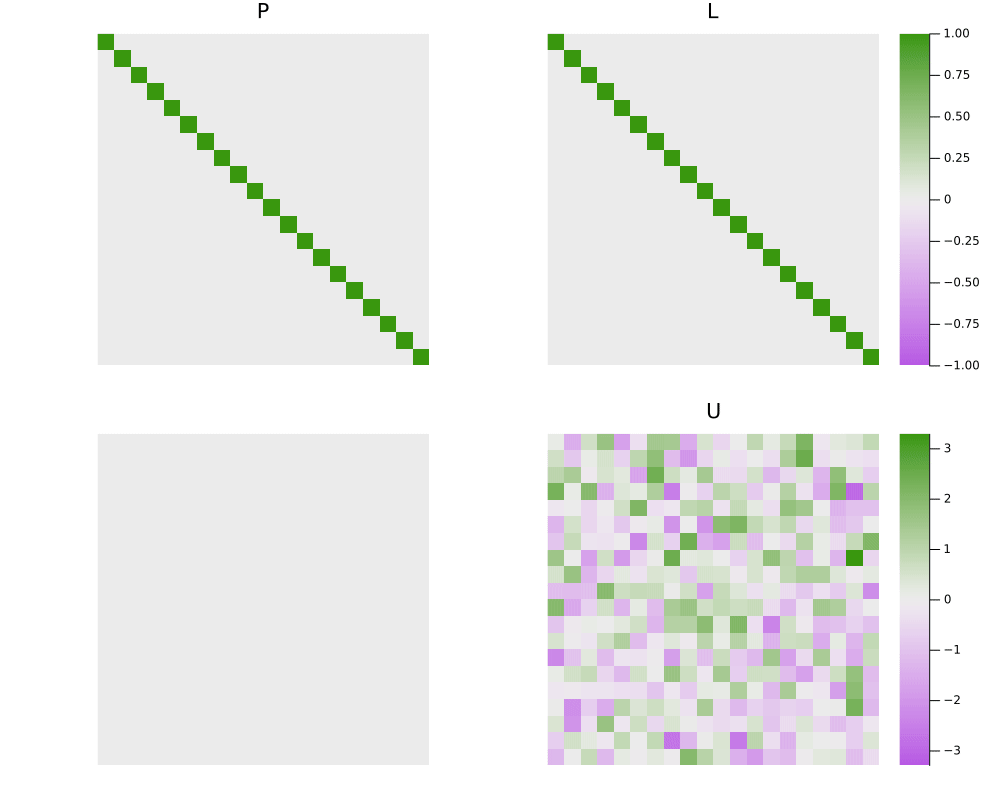

In [5]:
anim = Animation()
U = copy(A)
LU = lu(A, NoPivot())
scale = max(norm(A,Inf),norm(LU.L,Inf),norm(LU.U,Inf))
L = Matrix(1.0I,m,m)
P = Matrix(1.0I,m,m)
function plot_mats_plu(P,L,U,k,hi=false,Pₖ=nothing,Lₖ=nothing)
    m = size(U)[1]
    j = (k-1) + argmax(abs.(U[k:end,k]))
    u_scale = norm(U, Inf)
    l_plot = imshow(L, clim=(-1.0, 1.0), title="L")    
    u_plot = imshow(U, clim=(-u_scale, u_scale), title="U", colorbar=:bottom)
    p_plot = imshow(P, clim=(-1.0, 1.0), title="P", colorbar=false)
    if !isnothing(Pₖ)
        k_plot = imshow(Pₖ, clim=(-1.0,1.0), title="P$k", colorbar=false)
        plot!(u_plot,[k-0.5,m+0.5,m+0.5,k-0.5,k-0.5], [k+0.5,k+0.5,k-0.5,k-0.5,k+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        plot!(u_plot,[k-0.5,m+0.5,m+0.5,k-0.5,k-0.5], [j+0.5,j+0.5,j-0.5,j-0.5,j+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        s = argmax(P[k,:] .!= 0)
        t = argmax(P[j,:] .!= 0)
        plot!(p_plot,[s-0.5,s+0.5,s+0.5,s-0.5,s-0.5], [k+0.5,k+0.5,k-0.5,k-0.5,k+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        plot!(p_plot,[t-0.5,t+0.5,t+0.5,t-0.5,t-0.5], [k+0.5,k+0.5,k-0.5,k-0.5,k+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        plot!(p_plot,[s-0.5,s+0.5,s+0.5,s-0.5,s-0.5], [j+0.5,j+0.5,j-0.5,j-0.5,j+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        plot!(p_plot,[t-0.5,t+0.5,t+0.5,t-0.5,t-0.5], [j+0.5,j+0.5,j-0.5,j-0.5,j+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        if k > 1
            plot!(l_plot,[1-0.5,k-0.5,k-0.5,1-0.5,1-0.5], [k+0.5,k+0.5,k-0.5,k-0.5,k+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
            plot!(l_plot,[1-0.5,k-0.5,k-0.5,1-0.5,1-0.5], [j+0.5,j+0.5,j-0.5,j-0.5,j+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        end
    elseif !isnothing(Lₖ)
        k_plot = imshow(Lₖ, clim=(-1.0,1.0), title="L$k", colorbar=false)
        plot!(u_plot,[k-0.5,m+0.5,m+0.5,k-0.5,k-0.5], [m+0.5,m+0.5,k+0.5,k+0.5,m+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
    else
        k_plot = imshow(zeros(size(U)), clim=(-1.0,1.0), colorbar=false)
    end
    if hi
        plot!(u_plot, [k], [j], m=(4,:o), c=2)
    end
    plot!(u_plot, lim=(0.5,m+0.5))
    plot!(l_plot, lim=(0.5,m+0.5))
    plot!(p_plot, lim=(0.5,m+0.5))
    plot!(k_plot, lim=(0.5,m+0.5))
    p = plot(p_plot, l_plot, k_plot, u_plot, layout=(2,2), size=(1000,800))
    return p
end
frame(anim,plot_mats_plu(P,L,U,1))
for k in 1:(m-1)
    frame(anim,plot_mats_plu(P,L,U,k,true))
    j = (k-1) + argmax(abs.(U[k:end,k]))
    if j != k
    Pₖ = Matrix(1.0I,m,m)
        Pₖ[[k,j],[k,j]] = Pₖ[[j,k],[k,j]]
        frame(anim,plot_mats_plu(P,L,U,k,true,Pₖ))
        P = Pₖ * P
        U = Pₖ * U
        L = Pₖ * L *  Pₖ'
    end
    frame(anim,plot_mats_plu(P,L,U,k))
    Lₖ = Matrix(1.0I,m,m)
    Lₖ[k+1:m,k] = -U[k+1:m,k] / U[k,k]
    frame(anim,plot_mats_plu(P,L,U,k,false,nothing,Lₖ))
    L = L / Lₖ
    U = Lₖ * U
    U[(k+1):end,k] .= 0
    frame(anim,plot_mats_plu(P,L,U,k))
end
gif(anim, "plu.gif", fps=0.5)

### Recall $L_k$ form

$L_k$ is the $k$th unit lower triangular transformation, $U^{(k+1)} \gets L_k U^{(k)}$

$$L_k = I + \ell_k e_k^*, \quad \ell_{k,1:k} = 0, \quad \ell_{k,k+1:m} = -\frac{u_{k,k+1:m}^{(k)}}{u_{kk}^{(k)}}$$

By interchanging rows so that $|u_{k,k}^{(k)}| = \max_{j\geq k} |u_{j,k}|$,

$$\max_{ij} |(L_k)_{ij}| \leq 1.$$

Which is also true of the final $L$ matrix,

$$\max_{ij} |\ell_{ij}| \leq 1.$$

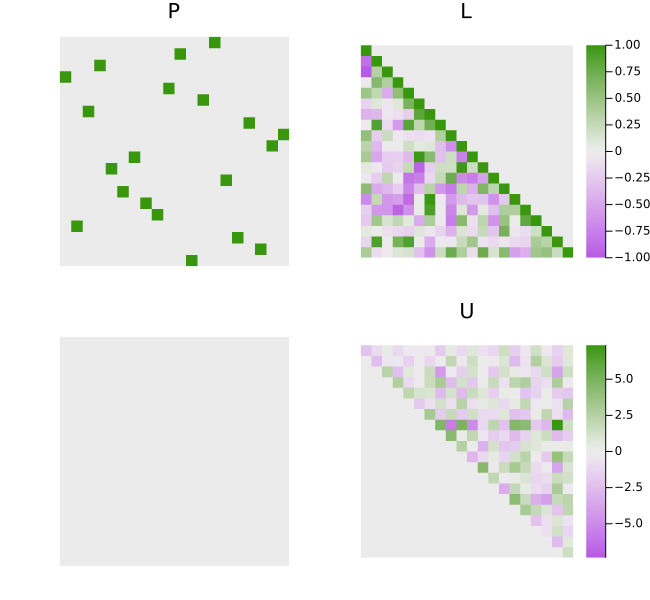

In [6]:
p = plot_mats_plu(P,L,U,m)
plot!(p,size=(650,600))

- Exists for all nonsingular $A$

- $\sim \frac{1}{2} m^2$ comparisons

- No growth in entries in $L$, what about $U$?

- Conditioning?

- Unstable / stable / backward stable:

  - of the factorization itself?
  - of solving equations via partial pivoted Gaussian elimination?

### Analysis of stability and conditioning is more complex than for QR

Consider the partial pivoted factorization of

$$
A + \delta A = \begin{bmatrix} 1 & 1 \\ 1 & 0
\end{bmatrix}
$$

How do we handle the tiebreak in the first pivot decision?

**No pivot:**

$$
P = \begin{bmatrix}1 & 0 \\ 0 & 1
\end{bmatrix},
L = \begin{bmatrix}1 & 0 \\ 1 & 1
\end{bmatrix},
U = \begin{bmatrix}1 & 1 \\ 0 & -1
\end{bmatrix}.
$$

**Pivot:**

$$
P = \begin{bmatrix}0 & 1 \\ 1 & 0
\end{bmatrix},
L = \begin{bmatrix}1 & 0 \\ 1 & 1
\end{bmatrix},
U = \begin{bmatrix}1 & 0 \\ 0 & 1
\end{bmatrix}.
$$

$\Rightarrow$ Whichever choice we will make, there will be $\tilde{A}$ close to $A$ such that $\|\tilde{U} - U\| = O(1)$, so the factorization is ill-conditioned,

$$\kappa_{A \mapsto \{P,L,U\}} = \infty.$$

End of story?

### First: treating pivots separately

Even though the choice of pivots is made during the factorization, the result ($PA = LU$) is the same as if we

1. knew $P$ ahead of time and computed $\hat{A} = P A$, and
2. computed $LU = \hat{A}$ without pivoting.

Let's first try to understand just the second step in isolation.

### Even without pivoting, $A \mapsto \{L,U\}$ is ill-conditioned

Recall the simple example from last time:

$$
\underbrace{
\begin{bmatrix}
\epsilon & 1 \\ 1 & 0
\end{bmatrix}
}_{A}
=
\underbrace{
\begin{bmatrix}
1 & 0 \\  \epsilon^{-1} & 1
\end{bmatrix}
}_{L}
\underbrace{
\begin{bmatrix}
\epsilon & 1 \\ 0 & -\epsilon^{-1}
\end{bmatrix}
}_{U}.
$$

$\kappa(A) \to 1$, $\|A\| \to 1$, as $\|L\|$ and $\|U\|$ diverge

$\Rightarrow$ $\|L\|$ and $\|U\|$ can't be bounded in a meaningful way by $\kappa(A)$

### But for random matrices... computed errors look correlated with  $\kappa$

In [7]:
l_errs = Float64[]; u_errs = Float64[]; κs = Float64[]
ms = 10:50
for m in ms
    L = UnitLowerTriangular(randn(m,m))[:,:]
    U = UpperTriangular(randn(m,m))[:,:]
    A = L * U
    L̃, Ũ = lu(A, NoPivot())
    push!(l_errs, norm(L - L̃) / norm(L))
    push!(u_errs, norm(U - Ũ) / norm(U))
    push!(κs, cond(A))
end

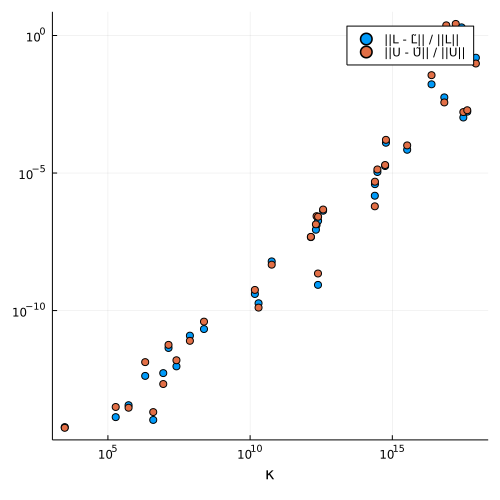

In [8]:
plot(κs, [l_errs u_errs], st=:scatter, scale=:log10, label=["||L - L̃|| / ||L||" "||U - Ũ|| / ||U||"], size=(500,500), xlabel="κ")

This is typical behavior when the algorithm is stable and the forward errors scale like $\kappa(A)$, but we just showed the second part isn't true.

### T&B Theorem 22.1

Let $A = LU$ of nonsingular $A \in \mathbb{C}^{m \times m}$ be computed by Gaussian elimination without pivoting on a computed satisfying the floating point axioms.  If $A$ has an LU factorization, then for small enough $\epsilon_{\text{machine}}$, the factorization completes successfully in floating point arithmetic (no zero pivots), and the computed matrices $\tilde{L}$ and $\tilde{U}$ satisfy

$$
\tilde{L}\tilde{U} = A + \delta A, \quad \frac{\|\delta A\|}{\|L\|\|U\|} = O(\epsilon_{\text{machine}})
$$

for some $\delta A$.

**How is this different from a typical backward stability result?**

Because $\|L\|$ and $\|U\|$ are not $O(\|A\|)$ in general, this is not a backward stability result.

### Second: add $P$ back into the analysis

$P$ is selected so that $\|L\| = O(1)$.  If that is taken into account, theorem 22.1 becomes,

$$
\tilde{L}\tilde{U} = A + \delta A, \quad \frac{\|\delta A\|}{\|U\|} = O(\epsilon_{\text{machine}})
$$

for some $\delta A$.

### Definition: growth factor $\rho_U$

$$\large \rho_U(A)= \frac{\max_{ij} |u_{ij}|}{\max_{ij} |a_{ij}|}$$


This is a ratio of norms (not induced $\|\cdot\|_\infty$, but $\|\cdot\|_\infty$ of the matrices as vectors).  Because of norm equivalence,

$$\large \|U\| = O(\rho_U(A) \|A\|).$$

If it can be shown that with partial pivoting $\rho_U(A) = O(1)$ (uniformly for all $A$ in $\mathbb{C}^{m \times m}$), then

$$\|U\| = O(\|A\|).$$

### T&B Theorem 22.2.

Let the factorization $PA = LU$ of $A\in \mathbb{C}^{m \times m}$ be computed by Gaussian elimination with partial pivoting on a computer satisfying the floating point axioms.  Then the computed matrices $\tilde{P}$,
$\tilde{L}$, and $\tilde{U}$ satisfy

$$
\tilde{L}\tilde{U} = \tilde{P} A + \delta A, \quad \frac{\|\delta A\|}{\|A\|} = O(\rho_U(A) \epsilon_{\text{machine}}),
$$

where $\rho$ is the growth factor for $A$.

If $|\ell_{ij}| < 1$ for each $i > j$, implying that there were no ties in the selection of pivots in exact arithmetic, then $\tilde P = P$ for all sufficiently small $\epsilon_{\text{machine}}$.

So,

$$\large \rho_U(A) = O(1)?$$

### Worst-Case Instability

Consider

$$
A = \begin{bmatrix}
1 & & & & 1 \\
-1 & 1 & & & 1 \\
-1 & -1 & 1 & & 1 \\
-1 & -1 & -1 & 1 & 1 \\
-1 & -1 & -1 & -1 & 1
\end{bmatrix}
$$

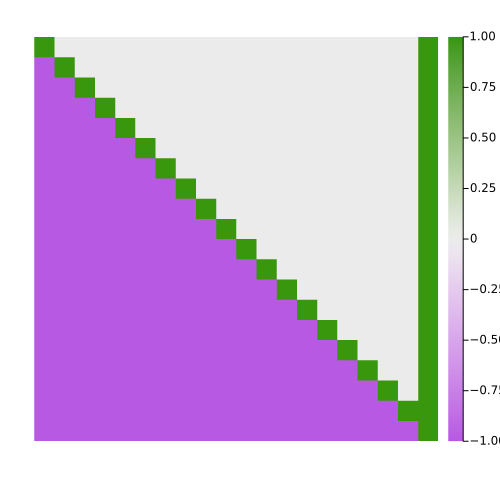

In [9]:
m = 20
A = UnitLowerTriangular(-ones(m,m))[:,:]; A[:,m] .= 1;
imshow(A, size=(500,500))

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/plu_growth.gif")
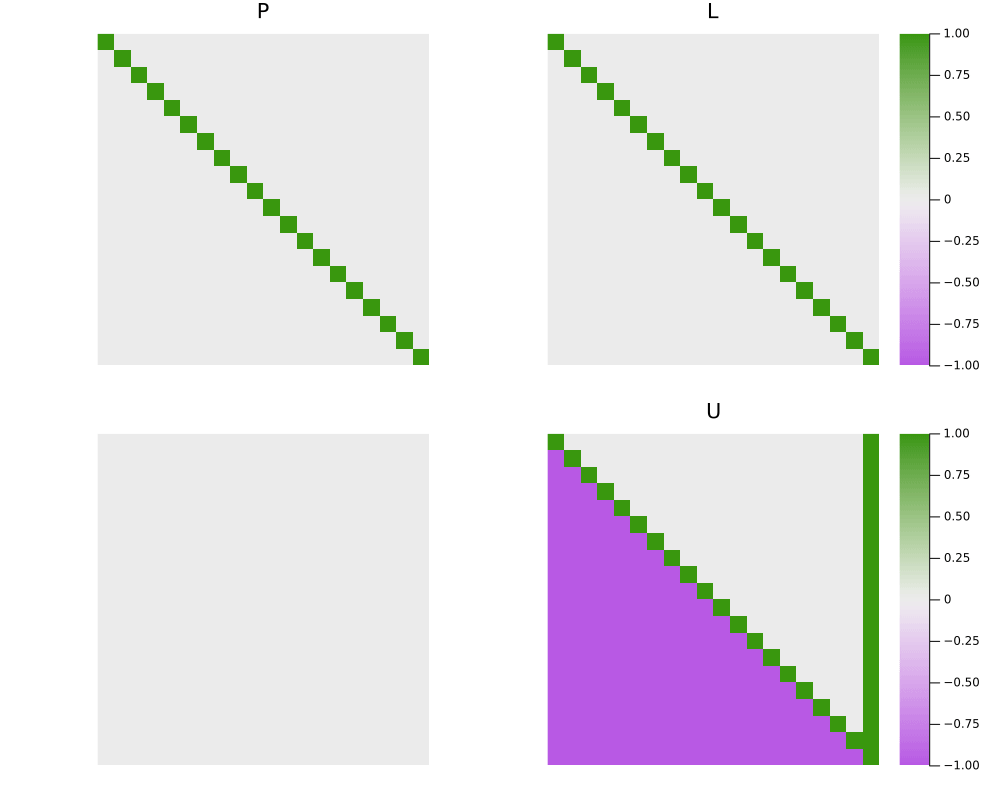

In [10]:
anim = Animation()
U = copy(A)
L = Matrix(1.0I,m,m)
P = Matrix(1.0I,m,m)
function plot_mats_plu(P,L,U,k,hi=false,Pₖ=nothing,Lₖ=nothing)
    m = size(U)[1]
    j = (k-1) + argmax(abs.(U[k:end,k]))
    u_scale = norm(U, Inf)
    l_plot = imshow(L, clim=(-1.0, 1.0), title="L")    
    u_plot = imshow(U, clim=(-u_scale, u_scale), title="U", colorbar=:bottom)
    p_plot = imshow(P, clim=(-1.0, 1.0), title="P", colorbar=false)
    if !isnothing(Pₖ)
        k_plot = imshow(Pₖ, clim=(-1.0,1.0), title="P$k", colorbar=false)
        plot!(u_plot,[k-0.5,m+0.5,m+0.5,k-0.5,k-0.5], [k+0.5,k+0.5,k-0.5,k-0.5,k+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        plot!(u_plot,[k-0.5,m+0.5,m+0.5,k-0.5,k-0.5], [j+0.5,j+0.5,j-0.5,j-0.5,j+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        s = argmax(P[k,:] .!= 0)
        t = argmax(P[j,:] .!= 0)
        plot!(p_plot,[s-0.5,s+0.5,s+0.5,s-0.5,s-0.5], [k+0.5,k+0.5,k-0.5,k-0.5,k+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        plot!(p_plot,[t-0.5,t+0.5,t+0.5,t-0.5,t-0.5], [k+0.5,k+0.5,k-0.5,k-0.5,k+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        plot!(p_plot,[s-0.5,s+0.5,s+0.5,s-0.5,s-0.5], [j+0.5,j+0.5,j-0.5,j-0.5,j+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        plot!(p_plot,[t-0.5,t+0.5,t+0.5,t-0.5,t-0.5], [j+0.5,j+0.5,j-0.5,j-0.5,j+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        if k > 1
            plot!(l_plot,[1-0.5,k-0.5,k-0.5,1-0.5,1-0.5], [k+0.5,k+0.5,k-0.5,k-0.5,k+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
            plot!(l_plot,[1-0.5,k-0.5,k-0.5,1-0.5,1-0.5], [j+0.5,j+0.5,j-0.5,j-0.5,j+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
        end
    elseif !isnothing(Lₖ)
        k_plot = imshow(Lₖ, clim=(-1.0,1.0), title="L$k", colorbar=false)
        plot!(u_plot,[k-0.5,m+0.5,m+0.5,k-0.5,k-0.5], [m+0.5,m+0.5,k+0.5,k+0.5,m+0.5], st=:shape, l=0, fillcolor=1, fillalpha=0.25, c=1)
    else
        k_plot = imshow(zeros(size(U)), clim=(-1.0,1.0), colorbar=false)
    end
    if hi
        plot!(u_plot, [k], [j], m=(4,:o), c=2)
    end
    plot!(u_plot, lim=(0.5,m+0.5))
    plot!(l_plot, lim=(0.5,m+0.5))
    plot!(p_plot, lim=(0.5,m+0.5))
    plot!(k_plot, lim=(0.5,m+0.5))
    p = plot(p_plot, l_plot, k_plot, u_plot, layout=(2,2), size=(1000,800))
    return p
end
frame(anim,plot_mats_plu(P,L,U,1))
for k in 1:(m-1)
    frame(anim,plot_mats_plu(P,L,U,k,true))
    j = (k-1) + argmax(abs.(U[k:end,k]))
    if j != k
    Pₖ = Matrix(1.0I,m,m)
        Pₖ[[k,j],[k,j]] = Pₖ[[j,k],[k,j]]
        frame(anim,plot_mats_plu(P,L,U,k,true,Pₖ))
        P = Pₖ * P
        U = Pₖ * U
        L = Pₖ * L *  Pₖ'
    end
    frame(anim,plot_mats_plu(P,L,U,k))
    Lₖ = Matrix(1.0I,m,m)
    Lₖ[k+1:m,k] = -U[k+1:m,k] / U[k,k]
    frame(anim,plot_mats_plu(P,L,U,k,false,nothing,Lₖ))
    L = L / Lₖ
    U = Lₖ * U
    U[(k+1):end,k] .= 0
    frame(anim,plot_mats_plu(P,L,U,k))
end
gif(anim, "plu_growth.gif", fps=2.0)

$$U = \begin{bmatrix}
1 & & & & 1 \\
& 1 & & & 2 \\
& & 1 & & 4 \\
& & & 1 & 8 \\
& & & & 16
\end{bmatrix}
$$

$$\rho_U(A) = 2^{m-1}$$

### T&B Exercise 22.1.

Show that for Gaussian elimination with partial pivoting applied to any matrix $A \in \mathbb{C}^{m \times m}$, the growth factor (22.2) satisfies $\rho \leq 2^{m-1}$.

### $\rho_U(A) = 2^{m-1}$ is catastrophic

Implies there are problems where the backward data $\delta A$ loses one bit of accuracy for each row of the matrix

In double precision, there are matrices as small as $m=54$ where $\tilde{L}\tilde{U}$ has no resemblance to $A$.

### $\rho_U(A) = 2^{m-1}$ is ... backward stable

**T&B Theorem 22.3.** According to the definition of $O(\epsilon_{\text{machine}})$ --

- $O(\epsilon_{\text{machine}})$ uniformly in data _of the same fixed space $X$_ (fixed $m$),

- $O(f(m) \epsilon_{\text{machine}})$ is $O(\epsilon_{\text{machine}})$ --

Gaussian elimination with partial pivoting is backward stable.

There are floating point matrices where $\frac{\|A - \tilde{L} \tilde{U}\|}{\|A\|} = O(2^{m-1} \epsilon_{\text{machine}})$ is a tight bound (HW4 Q5).  How can we use Gaussian elimination?

> Despite examples like [HW4 Q5], Gaussian elimination is utterly stable in practice.  Large factors $U$ never seem to appear in real applications. In [now seventy-five] years of computing, no matrix problems that excite an explosion of instability are known to have arisen under natural circumstances.

### Argument from random matrices

- Matrices from real problems are not random

- But the catastrophic growth factor matrix has _highly structured column spaces_, and column spaces in real problems looks more random than they look like that

### Experiment 1: random matrix growth factors

Growth factors of random matrices (like HW3 Q1) 

In [11]:
ρs = Float64[]
mns = Float64[]
ms = Int64.(round.( 2 .^ LinRange(3,10,50)))
n_samples = 10
for m in ms
    for n in 1:n_samples
        A = randn(m,m) ./ sqrt(m)
        LU = lu(A)
        ρ = maximum(abs.(LU.U)) / maximum(abs.(A))
        push!(mns, m)
        push!(ρs, ρ)
    end
end

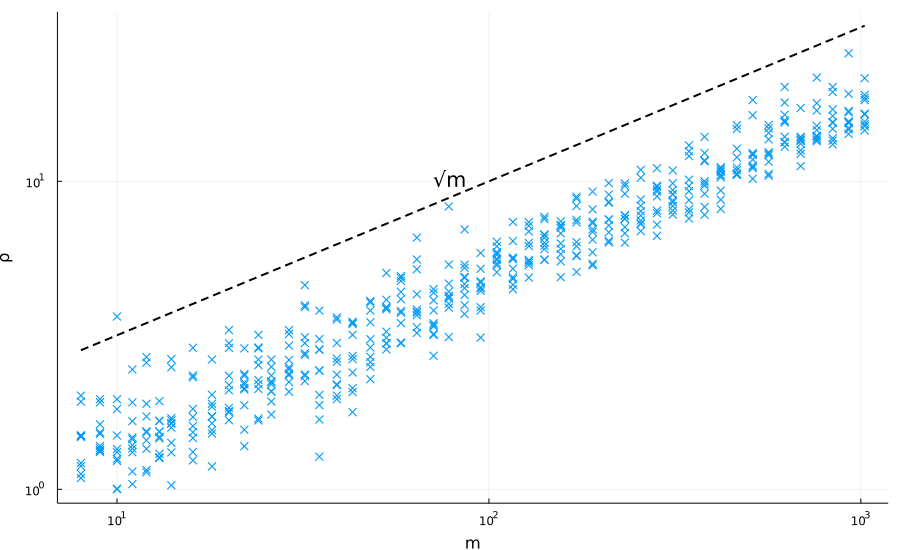

In [12]:
p = plot(mns, ρs, st=:scatter, xlabel="m", ylabel="ρ", m=:x, scale=:log10)
mid = div(length(mns),2)
plot!(p,[mns[1],mns[end]], [mns[1]^(1/2), mns[end]^(1/2)], l=(:black, 2, :dash))
annotate!(p, mns[mid], mns[mid]^(1/2), ("√m", :bottom, :right))

### Experiment 2: random matrix growth factor density

In [13]:
inv_bin_width = 5
num_bins = 100
all_bins = []
sizes = [8,16,32]
for m in sizes
    bins = zeros(num_bins)
    for i in 1:1000000
        A = randn(m,m) / sqrt(m)
        LU = lu(A)
        ρ = maximum(abs.(LU.U)) / maximum(abs.(A))
        bin = Int64.(ceil(ρ * inv_bin_width))
        if bin > num_bins
            resize!(bins, bin)
            bins[(num_bins+1):bin] .= 0.0
            num_bins = bin
        end
        bins[bin] += 1.0
    end
    push!(all_bins, bins)
end

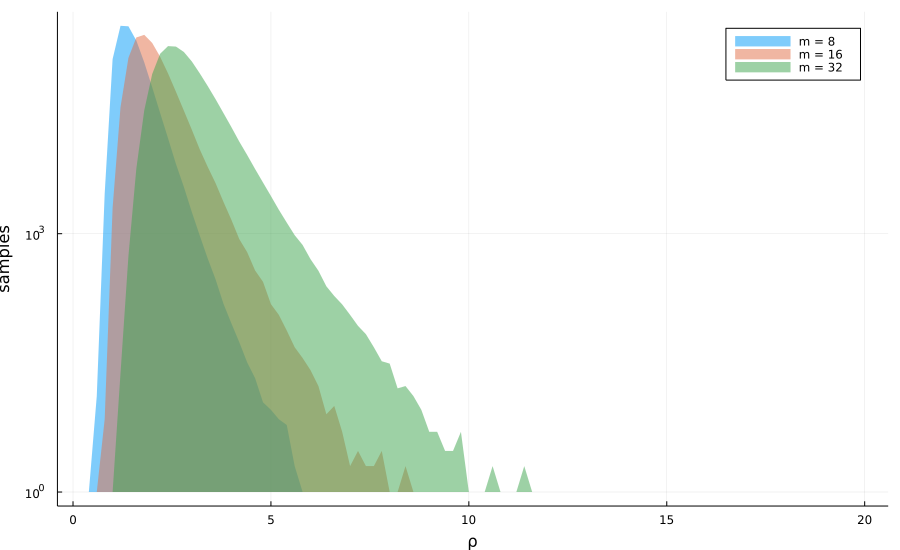

In [14]:
p = plot((1:num_bins) ./ inv_bin_width, max.(1,all_bins[1]), st=:shape, yscale=:log10, l=0, fillalpha=0.5,ylabel="samples", xlabel="ρ", label="m = 8")
plot!(p,(1:num_bins) ./ inv_bin_width, max.(1,all_bins[2]), st=:shape, yscale=:log10, l=0, fillalpha=0.5,label="m = 16")
plot!(p,(1:num_bins) ./ inv_bin_width, max.(1,all_bins[3]), st=:shape, yscale=:log10, l=0, fillalpha=0.5,label="m = 32")

### $U$ is relativey large $\Leftrightarrow$ $L^{-1}$ is absolutely large

$$U = L^{-1} P A$$

$$\frac{\|U\|}{\|A\|} \leq \frac{\|L^{-1}\|\|P\|\|A\|}{\|A\|} = \|L^{-1}\| O(1)$$

Random triangular matrices have huge inverses (implied by HW3 Q1)

### Experiment 3: $L^{-1}$ entry size

1. Create $L$ from $PA = LU$ factorization of random matrix $A$, plot its inverse
2. Randomly change the signs of the entries below the diagonal to create $\tilde{L}$, plot its inverse

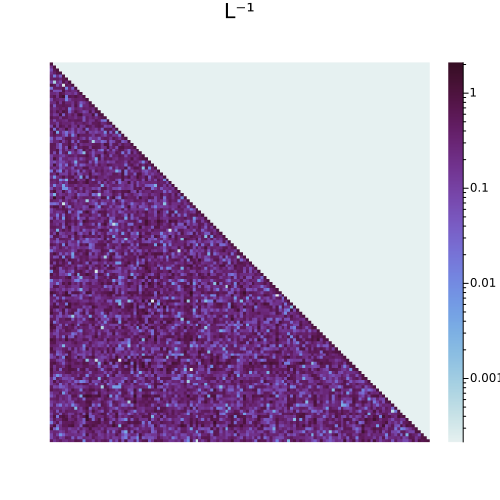

In [15]:
m = 128
A = randn(m,m) / sqrt(m)
LU = lu(A)
L = LU.L
Linv = inv(L)
small = minimum(abs.(Linv) + abs.(Linv)')
imshow(max.(abs.(Linv),small), c=:dense, colorbar_scale=:log10, size=(500,500), title="L⁻¹")

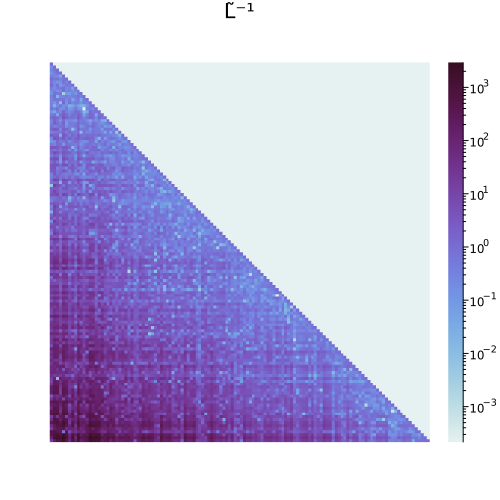

In [16]:
L̃ = UnitLowerTriangular(L .* sign.(randn(m,m)))
L̃inv = inv(L̃)
imshow(max.(abs.(L̃inv), small), c=:dense, colorbar_scale=:log10, title="L̃⁻¹", size=(500,500))

### Column spaces

$$PA = LU \quad\Leftrightarrow\quad A U^{-1} = P^* L$$

**Claim:** This means the _column spaces_ ($\mathrm{range}(A_{1:k})$ for each $k$) of $A$ are the column spaces of $P^* L$.

- $U^{-1}$ is upper triangular, doesn't change the column space when multiplied on the right

- If $L^{-1}$ is large, the column spaces are $L$ are very skewed

### Experiment 4: column space comparison

Take $\tilde{L}$ from the last experiment (has a large inverse) and compare the column spaces of $QR = A$ and $\tilde{Q}\tilde{R} = P^* \tilde{L}$

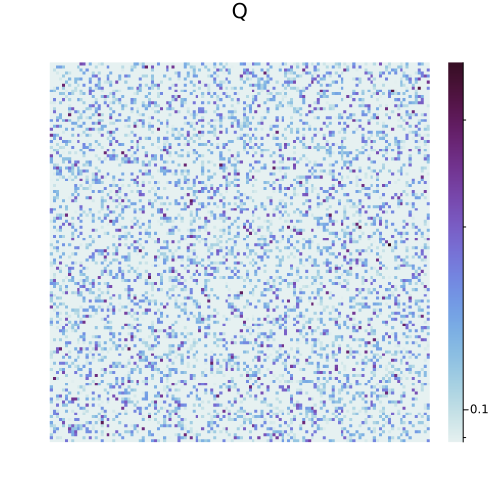

In [17]:
small = 1 / sqrt(m)
Q = qr(A).Q
imshow(max.(abs.(Q), small), colorbar_scale=:log10, c=:dense, title="Q", size=(500,500))

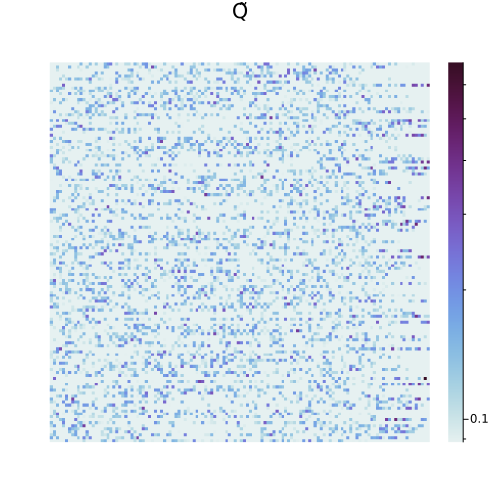

In [18]:
Q̃ = qr(LU.P' * L̃).Q
imshow(max.(abs.(Q̃), small), colorbar_scale=:log10, c=:dense, title="Q̃", size=(500,500))

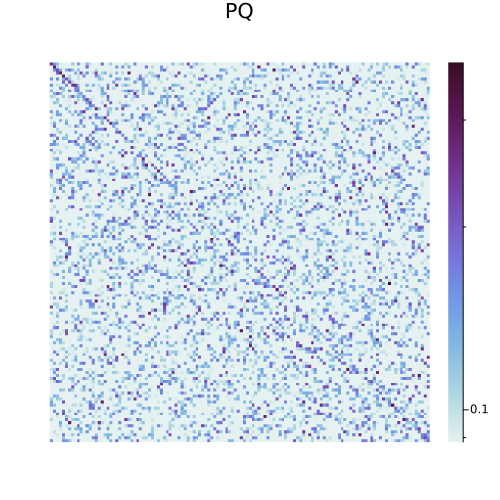

In [19]:
imshow(max.(abs.(LU.P * Q), small), colorbar_scale=:log10, c=:dense, title="PQ", size=(500,500))

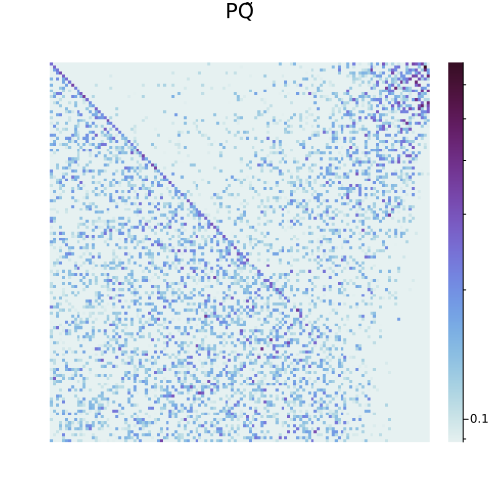

In [20]:
imshow(max.(abs.(LU.P * Q̃), small), colorbar_scale=:log10, c=:dense, title="PQ̃", size=(500,500))

### HW4 Q1 & Q2

- Try examples until you see the patterns
- Try to prove the pattern inductively

### HW4 Q4 (Strictly column dominant matrices don't exchange rows in PLU factorization)


_Strictly column dominant:_

$$\large |a_{kk}| > \sum_{j\neq k} |a_{jk}|.$$

- Clearly no row exchange in the first step
- Let $\tilde{A}_{2:k,2:k}$ be the trailing diagonal block after the first step: prove that $\tilde{A}_{2:k,2:k}$ is also strictly column dominant.
  - This is sufficent.  Why?
  - The rest is applying inequalities.

### HW4 Q5 (Creating a matrix with catastrophic backward errors)

The matrix $A_{\text{bad}}$ in these slides has a growth factor as large as possible, _but_ its entries are integers and no floating point errors will be made until $m > 52$.  Make a small perturbation $O(\epsilon)$ to $A_{\text{bad}}$.  But what small perturbation?

- This lecture showed that random matrices have well-conditioned factors $\sim$ a random perturbation won't work.

- Either work out from first principles which types of perturbations will cascade during LU factorization, or:

  - Break the matrix $A_{\text{bad}}$ into sections:

    1. lower triangle
    2. diagonal
    3. last column
    
  - Try perturbations in $\{-\epsilon, 0, +\epsilon\}$ applied the same way to whole sections.  Only $3^3 = 27$ cases to try!